In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jun  7 22:16:28 2023

@author: hzhang
"""

import os
import math
import sys
import copy
import scipy
import pickle

from scipy import sparse
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import spsolve
from numpy.linalg import norm
from numpy.linalg import qr
from  scipy.linalg import  svdvals
import jax.numpy as jnp
import numpy as np
import jax.random as random
from jax import pmap
from jax import vmap
from jax import jit
import jax.ops
import time
from jax import config
jax.config.update("jax_enable_x64", True)
from jax.scipy.special import logsumexp
import pathlib
from tempfile import TemporaryFile
import matplotlib.pyplot as plt

import pylab as pl
from IPython import display
 
colors=["#648FFF", "#785EF0", "#DC267F", "#FE6100", "#FFB000"]
import importlib
import EMUS_func_utils #import the module here, so that it can be reloaded.
importlib.reload(EMUS_func_utils)
from EMUS_func_utils import * # or whatever name you want.
font = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 16}
plt.rc('font', **font)
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['savefig.dpi'] = 300
import itertools
#%%
@jit 
def logansatz(s,fftW0,b0):
    Fsigma=jnp.fft.fft(2*s-1)
    theta=jnp.fft.ifft(fftW0*jnp.conj(Fsigma))+b0
    logx_sigma=jnp.sum(jnp.log(jnp.cosh(theta)))
#     x_sigma=jnp.exp(logx_sigma)
    return logx_sigma
logansatz1 = vmap(logansatz, (0, None, None), 0)
jlogansatz= jit(logansatz1)
logansatz2 = vmap(jlogansatz, (0, 0, 0), 0)
jjlogansatz = jit(logansatz2)

@jit
def compute(s,fftW0,b0):
    Fsigma=jnp.fft.fft(2*s-1)
    theta=jnp.fft.ifft(fftW0*jnp.conj(Fsigma))+b0
    logx_sigma=jnp.sum(jnp.log(jnp.cosh(theta)))
    tanhtheta=jnp.tanh(theta)
    dlogx_sigma_db=jnp.sum(tanhtheta,axis=-1)
    dlogx_sigma_dw=jnp.fft.ifft(jnp.fft.fft(tanhtheta)*Fsigma)
    dlogx_dweights=jnp.concatenate((dlogx_sigma_dw.flatten(),jnp.reshape(dlogx_sigma_db,(-1,))))
    return logx_sigma, dlogx_dweights
compute1 = vmap(compute, (0, None, None), 0)
jcompute = jit(compute1)
compute2 = vmap(jcompute, (None, 0, 0), 0)
jjcompute = jit(compute2)
compute3 = vmap(jjcompute, (0, None, None), 0)
jjjcompute = jit(compute3)

compute_respective = vmap(jcompute, (0, 0,0), 0)
jcompute_respective = jit(compute_respective)
 
@jit
def cvcompute(state):
    sames= state ^ state[(jnp.arange(d) + 1) % d]
    energy1 = 2*jnp.sum(sames)-d
    return -energy1/d
cvcompute1 = vmap(cvcompute, 0, 0)
jcvcompute= jit(cvcompute1) 
cvcompute2 = vmap(jcvcompute, 0, 0)
jjcvcompute = jit(cvcompute2)

 
 
def compute_gap(N):
    def fixed_point(current):
        d = 2*current.size
        quantum = np.arange(-d/4 + 1/2, d/4, 1)
        y = current[:, np.newaxis] - current[np.newaxis, :]
        y = 2*np.arctan(y)
        y = np.sum(y, axis = 1)/d + 2*np.pi*quantum/d
        y = np.tan(y/2)/2
        return(y)
    
    current = np.zeros(d//2)
    for i in range(1000):
        current1 = np.copy(fixed_point(current))
        if norm(current1-current)<1e-10:
            print("iterations=",i)
            break
        current=current1    
    ans = np.sum(-2/(4*current**2 + 1))
    E0 = 4*ans/d + 1
    
    energies=[]
    print("Pick minimum from %d candidates"%len(list(itertools.combinations(np.arange(-N/4, N/4+1e-8, 1), N//2-1))))
    for quantum in list(itertools.combinations(np.arange(-N/4, N/4+1e-8, 1), N//2-1)):
        quantum=np.array(quantum)
        z=quantum*0
        for i in range(1000):
            x=(z[:,np.newaxis]-z[np.newaxis,:])
            x=(2*np.pi*quantum+2*np.arctan(x/2).sum(axis=1))/N 
            z1=np.tan(x/2)
            if norm(z1-z)<1e-10:
                break
            z=z1
        ans = np.sum(-2/(z**2 + 1))
        ans = 4*ans/N + 1
        energies.append(ans)
    E1=np.array(energies).min()  
    print("N=",N)
    print("E0=",E0)
    print("E1=",E1)
    print("E1-E0=",E1-E0)
    return E1-E0 
    
def Hloc_boxplot(ax, fftW0, b0, color=None,label=None,d=100,alpha=5):
    if d==100:
        if delta==0.5:
            E0=-1.5002721151896314
        elif delta==1.0:
            E0=-1.772918283003674
        elif delta==1.5:
            E0=-2.093819885253906
        else:
            print("no defined E0")
    if d==200:
        if delta==0.5:
            E0=-1.5000680204043535
        elif delta==1.0:
            E0=-1.772671065044832
        elif delta==1.5:
            E0=-2.093740234375
        else:
            print("no defined E0")
    pool_states_list=np.load('/scratch/hz1994/vinla/pool/pool_cvunif_d%d.npy'%d)
    pool_states_list=pool_states_list[:2000]
    cvstates=jcvcompute(pool_states_list)
    logx_states_list=jlogansatz(pool_states_list,fftW0,b0 )
    Hloc_list=jqueryHx_x(pool_states_list,fftW0,b0,logx_states_list ).real
    
    cv_unique=np.unique(cvstates)
    Hloc_error_list=[] 
    for i, cv in enumerate(cv_unique):
        Hloc_error_list .append(abs(Hloc_list[cvstates==cv]/d-E0)) 
    
    Hlocerrormean=[np.mean(item) for item in Hloc_error_list ]
    ax=plot(ax,Hloc_error_list,cv_unique,color)
    return ax,  cv_unique, Hlocerrormean,Hloc_error_list
def plot(ax, Hloc_error_list,cv_unique,color=None,label=None): 
    if not color:
        color=get_next_color(ax)   
    bp=ax.boxplot(Hloc_error_list,positions=cv_unique,showbox =True,\
                         showfliers=False,widths=0.02,whis=1.5,\
                         boxprops= dict(linewidth=1.5, color=color),
                         medianprops=dict(color='black', linewidth=1.5),
             whiskerprops=dict(linestyle='-',linewidth=1.5, color=color))
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(bp[item], color=color)
    
    ax.set_yscale("log")

    cvplot=np.array([-1,-0.5,0,0.5,1])
    cvticklabels=[str(cv) for cv in cvplot]
    ax.set_xticks(cvplot)
    ax.set_xticklabels(cvticklabels)
    ax.set_ylabel(r"$|H\psi/\psi-E_0|$")    
    ax.set_xlabel(r"$s$")   
    ax.set_xlim([-1,1])
    ax.set_ylim([1e-6,1e1])
    return ax

In [2]:
mydict=dict({1.0:"42802917" ,  1.5:"42801859" , 0.5:"42802915"},)
enedict=dict({1.0:-1.772918283003674 ,  1.5:-2.093819885253906 , 0.5:-1.5002721151896314},)

@jit
def queryHx_x(state, fftW0, b0,logxstate):
    sames= state ^ state[(jnp.arange(d) + 1) % d]
    energy1 = 2*jnp.sum(sames)-d
    Hx1_x = -delta*energy1
     
    statesxy = jnp.repeat(jnp.expand_dims(state, -1), d, -1).T
    i0 = jnp.arange(d)
    
    statesxy = statesxy.at[i0,i0].set(~statesxy[i0,  i0])
    statesxy = statesxy.at[i0, (i0+1)%d].set(~statesxy[i0, (i0+1)%d])

    logxstatesxy,dlogxstatesxy=jcompute(statesxy, fftW0, b0)
    wave_ratios=jnp.exp(logxstatesxy-logxstate)
    sameswave_ratios=sames*wave_ratios
    Hx2_x = -2*jnp.sum(sameswave_ratios)    
    return Hx1_x+Hx2_x

queryHx_x1 = vmap(queryHx_x, (0, None, None,0), 0)
jqueryHx_x = jit(queryHx_x1)
queryHx_x2 = vmap(jqueryHx_x, (None, 0, 0,0), 0)
jjqueryHx_x = jit(queryHx_x2)

queryHx_x_respective = vmap(jqueryHx_x, (0, 0, 0,0), 0)
jjqueryHx_x_respective = jit(queryHx_x_respective) 


t=2000  
ind=31
delta=1.0
d=100
pool_states_list=np.load('/scratch/hz1994/vinla/pool/pool_cvunif_d%d.npy'%d)
pool_states_list=pool_states_list[:5000]
cvstates=jcvcompute(pool_states_list)
cv_unique=np.unique(cvstates)

gfolder=dict(zip([6,10,20,30,50],["44503335_alpha6","44508194_alpha10","44595551_alpha20","44877430_cvunif_alpha30","45873958_cvunif_alpha50"]))
 
for i,alpha in enumerate([6,10,20,30,50]):
    E=[]
    for ind in range(31,41):
        try:
            E_list=np.load(f"/scratch/hz1994/vinla/{gfolder[alpha]}/{ind}/E_list{ind}_L1_eps0.100_eps1_0.100_beta_0.950_delta_1.0.npy")
            E.append(E_list[1000:].mean())
        except:
            print(alpha,ind)
    print(alpha, f"{np.nanmean(np.array(E)):.3e}")

6 3.626e-05
10 1.486e-05
20 4.614e-06
30 2.353e-06
50 2.295e-06


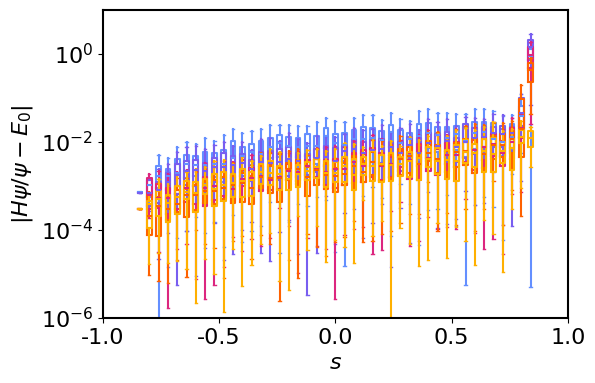

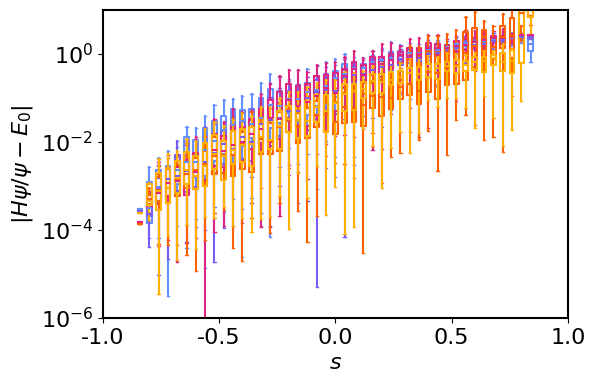

In [3]:
t=2000  
ind=31
delta=1.0
 
d=100
pool_states_list=np.load('/scratch/hz1994/vinla/pool/pool_cvunif_d%d.npy'%d)
pool_states_list=pool_states_list[:5000]
cvstates=jcvcompute(pool_states_list)
cv_unique=np.unique(cvstates)

gfolder=dict(zip([6,10,20,30,50],["44503335_alpha6","44508194_alpha10","44595551_alpha20","44877430_cvunif_alpha30","45873958_cvunif_alpha50"]))
cv_unique_list=[]
Hlocerrormean_list=[]
Hloc_error_list=[]

fig,ax=plt.subplots(figsize=[6,4] )
for i,alpha in enumerate([6,10,20,30,50]):
    w_list=np.load(f"/scratch/hz1994/vinla/{gfolder[alpha]}/{ind}/w_list{ind}_L1_eps0.100_eps1_0.100_beta_0.950_delta_1.0.npy")
    weights=w_list[t]
    W0=jnp.reshape(weights[:-alpha],(alpha,d))
    b0=jnp.reshape(weights[-alpha:],(alpha,1))
    fftW0=jnp.fft.fft(W0)  
    ax, cv_unique, Hlocerrormean,Hloc_error=Hloc_boxplot(ax , fftW0,b0, colors[i])

    cv_unique_list.append(cv_unique)
    Hlocerrormean_list.append(Hlocerrormean)
    Hloc_error_list.append(Hloc_error)
    
vfolder=dict(zip([6,10,20,30,50],["44481599_alpha6","44481597_alpha10","44646043_alpha20","46771418_alpha30","45936133_alpha50"]))
cv_unique_list_vmc=[]
Hlocerrormean_list_vmc=[]
Hloc_error_list_vmc=[]

fig,ax=plt.subplots(figsize=[6,4] )
for i,alpha in enumerate([6,10,20,30,50]):
    with open('/scratch/hz1994/vinla/'+ vfolder[alpha]+ '/SRXXZclean1_0/inputs'+str(31)+f'_{t}.dump', 'rb') as f:
        data = pickle.load(f)
    fftW0=data[3]
    b0=data[4] 
    ax, cv_unique, Hlocerrormean,Hloc_error=Hloc_boxplot(ax , fftW0,b0, colors[i])

    cv_unique_list_vmc.append(cv_unique)
    Hlocerrormean_list_vmc.append(Hlocerrormean)
    Hloc_error_list_vmc.append(Hloc_error)

In [4]:
t=2000  
ind=31
alpha=50
with open('/scratch/hz1994/vinla/'+ '45936133_alpha50'+ '/SRXXZclean1_0/inputs'+str(31)+f'_{t}.dump', 'rb') as f:
    data = pickle.load(f)
    fftW0=data[3]
    b0=data[4]  
ax, cv_unique_VMC50, Hlocerrormean_VMC50,Hloc_error_VMC50=Hloc_boxplot(ax , fftW0,b0, "k")


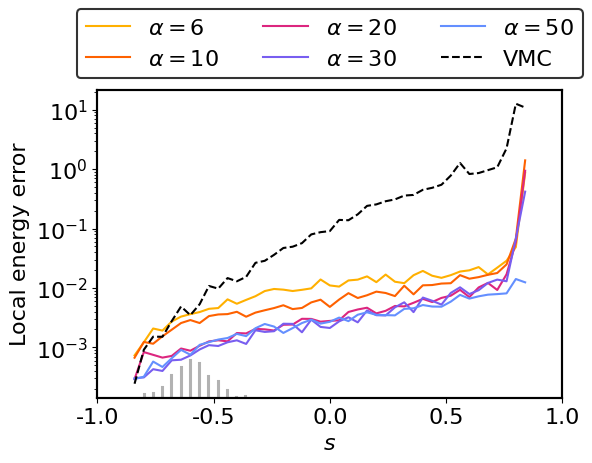

In [5]:
fig,ax=plt.subplots(figsize=[6,4] )
colors=["#648FFF", "#785EF0", "#DC267F", "#FE6100", "#FFB000"][::-1]
for i,alpha in enumerate([6,10,20,30,50]):
    plt.semilogy(cv_unique_list[i],Hlocerrormean_list[i],color=colors[i],label=r"$\alpha=$%d"%alpha)

plt.semilogy(cv_unique_VMC50, Hlocerrormean_VMC50,'k--',label="VMC")

ax1=ax.twinx()
states=np.load('/scratch/hz1994/vinla/'+ '46771418_alpha30'+ '/SRXXZclean1_0/states_list31.npy')
cvstates=jcvcompute(states[-5:].reshape(-1,d))
ax1.hist(np.array(cvstates),histtype="step",alpha=0.3,color='k',linewidth=1.5,bins=100)
ax1.set_ylim([0,800])
ax1.set_yticks([])

cvplot=np.array([-1, -0.5, 0, 0.5, 1])
cvticklabels=[str(cv) for cv in cvplot]
ax.set_xticks(cvplot)
ax.set_xticklabels(cvticklabels)
ax.set_xlabel(r"$s$")
ax.set_xlim([-1,1])
ax.set_xticks(cvplot)
ax.set_xticklabels(cvticklabels)
ax.set_xlabel(r"$s$")
ax.set_xlim([-1,1])
 
ax.set_ylabel(r"$\log P$")
ax.set_ylabel(r"$|H\psi/\psi-E_0|$")
ax.set_ylabel(r"Local energy error")

leg=ax.legend( prop={'size': 16},ncol=3,bbox_to_anchor=(0.5,1.15),loc='center')
# fig.legend(labels, loc='lower right', bbox_to_anchor=(1,-0.1), ncol=len(labels), bbox_transform=fig.transFigure)
leg.get_frame().set_linewidth(1.5)
leg.get_frame().set_edgecolor('black')

fig.savefig("/scratch/hz1994/vinla/Fig7_diff_alpha_energy.png",dpi=200, bbox_inches = "tight")
